<a href="https://colab.research.google.com/github/archanaqre/FinCausal-data-Classification/blob/main/FinCausal_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***IMPORTS***

In [ ]:
! pip install transformers
! pip install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.9 MB/s 
     |████████████████████████████████| 120 kB 68.4 MB/s 
     |████████████████████████████████| 6.6 MB 50.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 4.8 MB/s 
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=f08165025f7e6eb99243db594f08dd9e8d7e8158f7d791b78992b3b17d16d054
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
import re
from bs4 import BeautifulSoup

import os
import sys
import urllib
import gzip
from IPython.display import display, HTML

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# ***CHECK DEVICE***

In [ ]:
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

1
Tesla T4


# **DATA**

In [ ]:
# ===== 1 =====
data_df = pd.read_csv('/content/Fin.csv')
display(data_df)
data_df['Text']=data_df['Text'].apply(str)
result=data_df.dtypes
print(result)

,Text,Category
0,Florida raking in billions as Americans abando...,0
1,"Recently, changes to the U.S. tax code have en...",0
2,"MORE FROM FOXBUSINESS.COM... As it turns out, ...",0
3,"According to a new study from LendingTree, whi...",0
4,The Sunshine State drew in a net influx of abo...,1
...,...,...
22053,That's correct.,0
22054,Fining a company - which in effect just fines ...,0
22055,It was securing the bribe.,0
22056,Disrupting Democracy: When Big Tech Takes Over...,0


Text        object
Category     int64
dtype: object


In [ ]:
def remove_extra_spaces(text):
  return re.sub(' +', ' ', text)

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [ ]:
def remove_url(text):
  return re.sub('http://\S+|https://\S+', '', text)

In [ ]:
# Remove new line and tab tokens and extra spaces
data_df['Text'] = data_df['Text'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
data_df['Text'] = data_df['Text'].apply(lambda x: x.replace("TAB_TOKEN", " "))
data_df['Text'] = data_df['Text'].apply(remove_extra_spaces)
data_df['Text'] = data_df['Text'].apply(remove_html_tags)
data_df['Text'] = data_df['Text'].apply(remove_url)

In [ ]:
"""
Compute average number of words in each sentence and average number of sentences in each document.
"""
n_sent = 0
n_words = 0
for i in range(data_df.shape[0]):
    sent = tokenize.sent_tokenize(data_df.loc[i,'Text'])
    for satz in sent:
        n_words += len(tokenize.word_tokenize(satz))
    n_sent += len(sent)
    
print("Average number of words in each sentence: ",round(n_words/n_sent))
print("Average number of sentences in each document: ", round(n_sent/data_df.shape[0]))

Average number of words in each sentence:  25
Average number of sentences in each document:  2


In [ ]:
def cleanString(review, stopWords):  #----- REVIEW ? -----#
  lemmatizer = WordNetLemmatizer()
  returnString = ""
  sentence_token = tokenize.sent_tokenize(review)
  idx_list = []
  for j in range(len(sentence_token)):
    single_sentence = tokenize.word_tokenize(sentence_token[j])
    sentences_filtered = [(idx, lemmatizer.lemmatize(w.lower())) for idx, w in enumerate(single_sentence) if w.lower() not in stopWords and w.isalnum()]
    idx_list.append([x[0] for x in sentences_filtered])
    word_list = [x[1] for x in sentences_filtered]
    returnString = returnString + ' '.join(word_list) + ' . '

  return returnString, idx_list

In [ ]:
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

,Text,Category,Code
0,florida raking billion american abandon state ...,0,0
1,recently change tax code encouraged increasing...,0,0
2,turn however florida banking moving trend even...,0,0
3,according new study lendingtree analyzed irs d...,0,0
4,sunshine state drew net influx billion adjuste...,1,1


In [ ]:
# Split code
def split_df(dataframe, column_name, training_split = 0.6, validation_split = 0.2, test_split = 0.2):
  total = len(dataframe.index)

  train = dataframe.reset_index().groupby(column_name).apply(lambda x: x.sample(frac=training_split))\
    .reset_index(drop=True).set_index('index')
  train = train.sample(frac=1)
  temp_df = dataframe.drop(train.index)
  validation = temp_df.reset_index().groupby(column_name)\
    .apply(lambda x: x.sample(frac=validation_split/(test_split+validation_split)))\
           .reset_index(drop=True).set_index('index')
  validation = validation.sample(frac=1)
  test = temp_df.drop(validation.index)
  test = test.sample(frac=1)
    
  print('Total: ', len(dataframe))
  print('Training: ', len(train), ', Percentage: ', len(train)/len(dataframe))
  print('Validation: ', len(validation), ', Percentage: ', len(validation)/len(dataframe))
  print('Test:', len(test), ', Percentage: ', len(test)/len(dataframe))

  return train, validation, test

In [ ]:
train, validation, test = split_df(data_cleaned, 'Code',0.8,0.1,0.1)

Total:  22058
Training:  17646 , Percentage:  0.7999818659896636
Validation:  2206 , Percentage:  0.10000906700516819
Test: 2206 , Percentage:  0.10000906700516819


In [ ]:
# =====Trial splitting code =====

from sklearn.model_selection import train_test_split
# split the data into train and test set
train, test = train_test_split(data_cleaned, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in train:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

In [ ]:
import textwrap
wrapper = textwrap.TextWrapper(width = 80)
text = data_df.iloc[0].Text
tokens = tokenizer.tokenize(text)
#print(tokens)
print(wrapper.fill(text))
print()
print(len(tokens))

Florida raking in billions as Americans abandon high-tax states By Brittany De
LeaEconomic IndicatorsFOXBusiness  video  DeBianchi Real Estate's Samantha
DeBianchi gives her take on the new mansion tax in NYC and the great tax exodus.
State governments can benefit greatly from an influx of movers  -  enjoying
everything from increased tax revenues to new business activity.

73


In [ ]:
def length(text):
  tokens = tokenizer.tokenize(text)
  return len(tokens)

In [ ]:
data_df['Length of tokens'] = data_df['Text'].apply(length)

In [ ]:
data_df

,Text,Category
0,Florida raking in billions as Americans abando...,0
1,"Recently, changes to the U.S. tax code have en...",0
2,"MORE FROM FOXBUSINESS.COM... As it turns out, ...",0
3,"According to a new study from LendingTree, whi...",0
4,The Sunshine State drew in a net influx of abo...,1
...,...,...
22053,That's correct.,0
22054,Fining a company - which in effect just fines ...,0
22055,It was securing the bribe.,0
22056,Disrupting Democracy: When Big Tech Takes Over...,0


In [ ]:
column = data_df['Length of tokens']
max_value = column.max()
print(max_value)
print()
max_index = column.idxmax()
print(max_index)

1908

14622


In [ ]:
import numpy as np
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []

# Record the length of each sequence(after truncating to 512)
lengths = []

print("Tokenizing comments...")

for sentence in train.Text:
  # Report progress:
  if((len(input_ids) % 2000) == 0):
    print(" Read {:,} sentence.".format(len(input_ids)))

  encoded_sent = tokenizer.encode(
      sentence,
      add_special_tokens = True,
                                  # max_length = 512,
                                  # return_tensor = 'pt'
                                  )
  # Add the encoded sentence to the list
  input_ids.append(encoded_sent)

  # Record the truncated length
  lengths.append(len(encoded_sent))
print('DONE.')
print('{:>10,} text'.format(len(input_ids)))

Tokenizing comments...
 Read 0 sentence.
 Read 2,000 sentence.
 Read 4,000 sentence.
 Read 6,000 sentence.
 Read 8,000 sentence.
 Read 10,000 sentence.
 Read 12,000 sentence.


Token indices sequence length is longer than the specified maximum sequence length for this model (731 > 512). Running this sequence through the model will result in indexing errors


 Read 14,000 sentence.
 Read 16,000 sentence.
DONE.
    17,646 text


In [ ]:
import numpy as np
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []

# Record the length of each sequence(after truncating to 512)
lengths = []

print("Tokenizing comments...")

for sentence in validation.Text:
  # Report progress:
  if((len(input_ids) % 2000) == 0):
    print(" Read {:,} sentence.".format(len(input_ids)))

  encoded_sent = tokenizer.encode(
      sentence,
      add_special_tokens = True,
                                  # max_length = 512,
                                  # return_tensor = 'pt'
                                  )
  # Add the encoded sentence to the list
  input_ids.append(encoded_sent)

  # Record the truncated length
  lengths.append(len(encoded_sent))
print('DONE.')
print('{:>10,} text'.format(len(input_ids)))

Tokenizing comments...
 Read 0 sentence.
 Read 2,000 sentence.
DONE.
     2,206 text


In [ ]:
min(lengths)

3

In [ ]:
max(lengths)

731

In [ ]:
np.median(lengths)

21.5

Text(-1.6650000000000063, 0.5, '# of text')

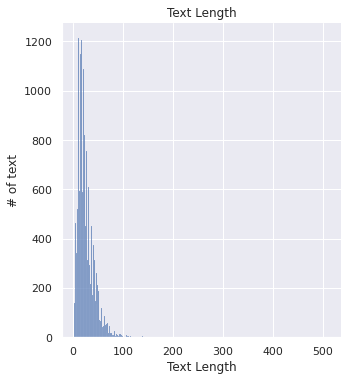

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the plot size and font size
sns.set(style = 'darkgrid')
plt.rcParams["figure.figsize"] = (20,20)

# Truncate any comment lengths greater than 512
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of text lengths
sns.displot(lengths, kde = False, rug = False)

plt.title("Text Length")
plt.xlabel("Text Length")
plt.ylabel('# of text')

In [ ]:
# Count the number of sentences that had to be truncated to 512 tokens
num_truncated = lengths.count(512)

# Compare this to total number of training sentences
num_sentences = len(lengths)
prcnt = float(num_truncated)/float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than 512 tokens'.format(num_truncated, num_sentences, prcnt))

1 of 17,646 sentences (0.0%) in the training set are longer than 512 tokens


Pad and truncate the text

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length
MAX_LEN = 128

# Pad our input tokens with value 0
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long", value = 0, truncating = 'post', padding = 'post')
print("Done")

Done


The ATTENTION MASK makes it explicit which tokens are actual words versus which are padding.

In [ ]:
# Create attention mask
attention_masks = []

for sent in input_ids:
  att_mask = [int(token_id>0) for token_id in sent]

  # Store the attention mask for this sentence
  attention_masks.append(att_mask)

In [ ]:
train_in

Final data prep

In [ ]:
train_masks, validation_masks, _, _ = 

In [ ]:
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_SENTENCE_NUM = 40 # maximum number of sentences in one document
MAX_WORD_NUM = 50     # maximum number of words in each sentence
EMBED_SIZE = 300      # vector size of word embedding

In [ ]:
def cleanString(review, stopWords):  #----- REVIEW ? -----#
  lemmatizer = WordNetLemmatizer()
  returnString = ""
  sentence_token = tokenize.sent_tokenize(review) # review = "Text"
  idx_list = []
  for j in range(len(sentence_token)):
    single_sentence = tokenize.word_tokenize(sentence_token[j])
    sentences_filtered = [(idx, lemmatizer.lemmatize(w.lower())) for idx, w in enumerate(single_sentence) if w.lower() not in stopWords and w.isalnum()]
    idx_list.append([x[0] for x in sentences_filtered])
    word_list = [x[1] for x in sentences_filtered]
    returnString = returnString + ' '.join(word_list) + ' . '

  return returnString, idx_list

In [ ]:
"""
Cleans raw data using the cleanString() function from above.
English stopwords are used from nltk library.
Cleaned dataset is saved in 'data_cleaned' pandas dataframe.
Labels are converted to numbers,
"""
articles = []
n = data_df['Text'].shape[0]
col_number = data_df.columns.get_loc('Text')
stopWords = set(stopwords.words('english'))
data_cleaned = data_df.copy()
for i in range(n):
    temp_string,idx_string = cleanString(data_df.iloc[i,col_number],stopWords)
    articles.append(temp_string)
    print(str(i+1)+' of '+str(n)+" articles cleaned.",end='\r')
    
data_cleaned.loc[:,'Text'] = pd.Series(articles,index=data_df.index)
data_cleaned.loc[:,'Category'] = pd.Categorical(data_cleaned.Category)
data_cleaned['Code'] = data_cleaned.Category.cat.codes
categoryToCode = dict( enumerate(data_cleaned['Category'].cat.categories))

data_cleaned.head()

In [ ]:
data_df.drop("Length of tokens", axis = 1, inplace = True)

In [ ]:
data_cleaned.drop("Length of tokens", axis = 1, inplace = True)


In [ ]:
data_cleaned.drop("Category", axis = 1, inplace = True)

In [ ]:
train['Text'].reset_index()

,index,Text
0,1463,regional player attribute standard product ove...
1,4403,side job blog supplemental income everything c...
2,19225,look additional capital raise believe first al...
3,20147,bank deposit reflected unequal distribution .
4,17257,adjusted ebitda grew 76 compared period 2018 .
...,...,...
17641,3663,precondition application special tax rate resp...
17642,6662,also prepare financial statement trading profi...
17643,8039,centred around experiential learning wealth ma...
17644,17608,tweet investor often rely healthcare sector sa...


In [ ]:
validation_inputs = validation['Text']
validation_labels = validation['Code']
train_inputs = train['Text']
train_labels = train['Code']

In [ ]:
validation

,Text,Category,Code
index,,,
18427,also diplomacy .,0,0
11107,response delay world bank rated overall implem...,0,0
13267,interactive workshop style event successful ma...,1,1
10960,though among scheduled speaker today new york ...,0,0
8855,company suite proprietary complementary techno...,0,0
...,...,...,...
11228,another one horizon . yes yes .,0,0
1538,unfortunately receive dividend deemed taxable ...,0,0
14244,single 100 bill altair would built million ret...,0,0


--------------------------------------------------------------------------------

In [ ]:
! pip install transformers
! pip install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 15.4 MB/s 
     |████████████████████████████████| 163 kB 65.7 MB/s 
     |████████████████████████████████| 6.6 MB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 13.5 MB/s 
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=423b0cf895166c7343196bd5a19990d621fc464ba208416db2f317d4cdfcf658
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
import re
from bs4 import BeautifulSoup

import os
import sys
import urllib
import gzip
from IPython.display import display, HTML

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

1
Tesla T4


In [ ]:
data_df = pd.read_csv('/content/Fin.csv')
display(data_df)
data_df['Text']=data_df['Text'].apply(str)

,Text,Category
0,Florida raking in billions as Americans abando...,0
1,"Recently, changes to the U.S. tax code have en...",0
2,"MORE FROM FOXBUSINESS.COM... As it turns out, ...",0
3,"According to a new study from LendingTree, whi...",0
4,The Sunshine State drew in a net influx of abo...,1
...,...,...
22053,That's correct.,0
22054,Fining a company - which in effect just fines ...,0
22055,It was securing the bribe.,0
22056,Disrupting Democracy: When Big Tech Takes Over...,0


In [ ]:
#Testing_1 = data_df['Text'].tolist()
#type(Testing_1)
#Testing_2 = data_df.Text.values
#Testing_2)

array(["Florida raking in billions as Americans abandon high-tax states By Brittany De LeaEconomic IndicatorsFOXBusiness  video  DeBianchi Real Estate's Samantha DeBianchi gives her take on the new mansion tax in NYC and the great tax exodus. State governments can benefit greatly from an influx of movers  -  enjoying everything from increased tax revenues to new business activity.",
       'Recently, changes to the U.S. tax code have encouraged an increasing number of people to move  -  taking their cash to lower-tax states like Florida.',
       'MORE FROM FOXBUSINESS.COM... As it turns out, however, Florida has been banking on moving trends even prior to the implementation of the new tax law.',
       ..., 'It was securing the bribe.',
       'Disrupting Democracy: When Big Tech Takes Over a City  Sam Ross-Brown  Google partner Sidewalk Labs wants to remake the Toronto waterfront as a privately run digital development. It may really be a digital dystopia.',
       "Google Is Like Fac

In [ ]:
def remove_extra_spaces(text):
  return re.sub(' +', ' ', text)

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [ ]:
def remove_url(text):
  return re.sub('http://\S+|https://\S+', '', text)

In [ ]:
# Remove new line and tab tokens and extra spaces
data_df['Text'] = data_df['Text'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
data_df['Text'] = data_df['Text'].apply(lambda x: x.replace("TAB_TOKEN", " "))
data_df['Text'] = data_df['Text'].apply(remove_extra_spaces)
data_df['Text'] = data_df['Text'].apply(remove_html_tags)
data_df['Text'] = data_df['Text'].apply(remove_url)

In [ ]:
# split the data into train and test set
train, test = train_test_split(data_df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
#testing_2 = train.Text.values
for sentence in train.Text:
  print (type(sentence))
  break

<class 'str'>


In [ ]:
train_text = train.Text.values
train_category = train.Category.values

In [ ]:
import numpy as np
# Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []

# Record the length of each sequence(after truncating to 512)
lengths = []

print("Tokenizing comments...")

for sentence in train_text:
  # Report progress:
  if((len(input_ids) % 2000) == 0):
    print(" Read {:,} sentence.".format(len(input_ids)))

  encoded_sent = tokenizer.encode(
      sentence,
      add_special_tokens = True,
                                  # max_length = 512,
                                  # return_tensor = 'pt'
                                  )
  # Add the encoded sentence to the list
  input_ids.append(encoded_sent)

  # Record the truncated length
  lengths.append(len(encoded_sent))
print('DONE.')
print('{:>10,} text'.format(len(input_ids)))

Tokenizing comments...
 Read 0 sentence.
 Read 2,000 sentence.
 Read 4,000 sentence.
 Read 6,000 sentence.
 Read 8,000 sentence.
 Read 10,000 sentence.
 Read 12,000 sentence.
 Read 14,000 sentence.
 Read 16,000 sentence.
DONE.
    17,646 text


In [ ]:
print(min(lengths))
print(max(lengths))
print(np.median(lengths))

3
1910
38.0


Text(-1.6650000000000063, 0.5, '# of text')

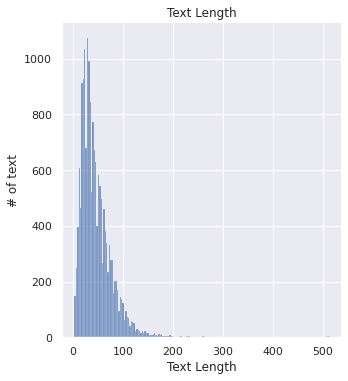

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase the plot size and font size
sns.set(style = 'darkgrid')
plt.rcParams["figure.figsize"] = (20,20)

# Truncate any comment lengths greater than 512
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of text lengths
sns.displot(lengths, kde = False, rug = False)

plt.title("Text Length")
plt.xlabel("Text Length")
plt.ylabel('# of text')

In [ ]:
from keras.preprocessing.sequence import pad_sequences

# Set the required sequence length
MAX_LEN = 128

# Pad our input tokens with value 0
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long", value = 0, truncating = 'post', padding = 'post')
print("Done")

Done


In [ ]:
# Create attention mask
attention_masks = []

for sent in input_ids:
  att_mask = [int(token_id>0) for token_id in sent]

  # Store the attention mask for this sentence
  attention_masks.append(att_mask)

In [ ]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, train_category, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(input_ids, train_category, random_state = 2018, test_size = 0.1)

In [ ]:
ans = train.Category.values
ans2 = torch.tensor(ans)
ans

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# Create DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

total_steps = len(train_dataloader) * epochs

# Create a learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds = elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)

# Store the average loss for plotting
loss_values = []

for epoch_i in range(0, epochs):
  print("")
  print("===== Epoch {:} / {:} =====".format(epoch_i+1, epochs))
  print("Training ...")

  t0 = time.time()

  # Reset the total loss for this epoch
  total_loss = 0

  model.train()

  for step, batch in enumerate(train_dataloader):
    if step%100 == 0 and not step == 0:
      # Calculate elapsed time
      elapsed = format_time(time.time() - t0)
      print("Batch {:>5,} of {:>5}. Elapsed: {:}".format(step, len(train_dataloader), elapsed))

    b_inputs_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    model.zero_grad()

    outputs = model(b_inputs_ids, token_type_ids = None, attention_mask = b_input_mask, labels = b_labels)

    loss = outputs[0]

    total_loss += loss.item()

    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    scheduler.step()

  avg_train_loss = total_loss / len(train_dataloader)
  loss_values.append(avg_train_loss)

  print("")
  print(" Average training loss: {0:.2f}".format(avg_train_loss))
  print(" Training epoch took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Running validation...")

  t0 = time.time()
  model.eval()

  # Tracking variables
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
    
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Calculate the accuracy for this batch of test sentences
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    # Accumulate the total accuracy
    eval_accuracy += tmp_eval_accuracy

    # Track the number of batches
    nb_eval_steps += 1

  print(" Accuracy: {0:2f}".format(eval_accuracy/nb_eval_steps))
  print(" Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete")


===== Epoch 1 / 4 =====
Training ...
Batch   100 of   497. Elapsed: 0:00:59
Batch   200 of   497. Elapsed: 0:01:58
Batch   300 of   497. Elapsed: 0:02:56
Batch   400 of   497. Elapsed: 0:03:54

 Average training loss: nan
 Training epoch took: 0:04:50

Running validation...
 Accuracy: 0.936719
 Validation took: 0:00:11

===== Epoch 2 / 4 =====
Training ...


KeyboardInterrupt: ignored

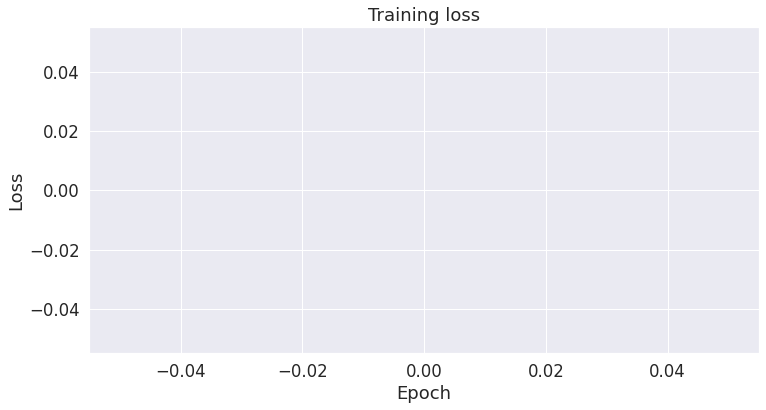

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "darkgrid")

sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (12, 6)
plt.plot(loss_values, 'b-o')

# Label the plot
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# ***NEW TEST***

## 1 if text contains causal relation, 0 otherwise

In [1]:
! pip install transformers
! pip install theano

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 28.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
     |████████████████████████████████| 163 kB 69.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 35.4 MB/s 
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668111 sha256=fb9b693539bd1b835e6e62b9744bc3c12a0b700d61256e352be5e9f810491f2b
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built theano


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import string
import requests
import re
from bs4 import BeautifulSoup

import os
import sys
import urllib
import gzip
from IPython.display import display, HTML

import nltk
from nltk import tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

import pip
import theano
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras import initializers as initializers, regularizers, constraints
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Convolution2D, MaxPooling2D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Sequential, Model, load_model
from keras import backend as K
from tensorflow.keras.layers import Layer
from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
import tensorflow as tf

# Get the GPU device name
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [4]:
import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")

1
Tesla T4


In [5]:
documents = pd.read_csv('/content/Fin.csv')
documents['Text'] = documents['Text'].apply(str)
documents.head()

,Text,Category
0,Florida raking in billions as Americans abando...,0
1,"Recently, changes to the U.S. tax code have en...",0
2,"MORE FROM FOXBUSINESS.COM... As it turns out, ...",0
3,"According to a new study from LendingTree, whi...",0
4,The Sunshine State drew in a net influx of abo...,1


In [6]:
category = documents["Category"]
category

0        0
1        0
2        0
3        0
4        1
        ..
22053    0
22054    0
22055    0
22056    0
22057    0
Name: Category, Length: 22058, dtype: int64

In [7]:
documents["Category"].value_counts()

0    20479
1     1579
Name: Category, dtype: int64

In [ ]:
def remove_extra_spaces(text):
  return re.sub(' +', ' ', text)

In [ ]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [ ]:
def remove_url(text):
  return re.sub('http://\S+|https://\S+', '', text)

In [ ]:
documents['Text'] = documents['Text'].apply(remove_extra_spaces)
documents['Text'] = documents['Text'].apply(remove_html_tags)
documents['Text'] = documents['Text'].apply(remove_url)

In [8]:
# split the data into train and test set
train_documents, test_documents = train_test_split(documents, test_size=0.2, random_state=42, shuffle=True)

In [9]:
train_documents.head(100)

,Text,Category
3024,Frank Licari: Pleasure.,0
19320,It shows the performance of the Japanese Econo...,0
4832,Let's hope they don't. More troubling is the d...,0
22045,The problem for Facebook is that this was a sp...,0
6053,The business's quarterly revenue was down 10.2...,0
...,...,...
20290,"In fact, on August 26, our Currency Pro Servic...",0
13141,44.15% of the stock is owned by institutional ...,0
14194,"But right alongside him, thousands of ordinary...",0
6896,"Till FY 2018-19, Rs. 32,886 crore towards taxe...",0


In [10]:
train_documents['Category'].value_counts()

0    16381
1     1265
Name: Category, dtype: int64

In [11]:
test_documents.head()

,Text,Category
18027,Close Close,0
4894,Our approach embraces a number of interactive ...,0
12286,5,0
17870,(Steve McLean RENX) Fundamentals for the apar...,0
19586,The analyst stated that the price was below va...,0


In [12]:
test_documents['Category'].value_counts()

0    4098
1     314
Name: Category, dtype: int64

In [13]:
! pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from transformers import BertTokenizer

# Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
text = train_documents.iloc[0].Text
tokens = tokenizer.tokenize(text)
print(len(tokens))
print("Original Text")
print(text)
print(tokens)

7
Original Text
Frank Licari:  Pleasure.
['frank', 'li', '##car', '##i', ':', 'pleasure', '.']


In [16]:
import numpy as np

# Tokenize all of the sentences and map the tokens to their token IDs
input_ids = []

# Record the length of each sequence (after truncating to 512)
lengths= []

print("Tokenizing comments ...")

for sen in train_documents.Text:
  if ((len(input_ids)) % 2000 == 0):
    print("Read {:,} comments".format(len(input_ids)))

  encoded_sent = tokenizer.encode(sen, add_special_tokens = True)

  # Add the encoded sentence to the list
  input_ids.append(encoded_sent)

  # Record the truncated length
  lengths.append(len(encoded_sent))

print("Done.")
print("{:>10,} comments".format(len(input_ids)))

Tokenizing comments ...
Read 0 comments
Read 2,000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


Read 4,000 comments
Read 6,000 comments
Read 8,000 comments
Read 10,000 comments
Read 12,000 comments
Read 14,000 comments
Read 16,000 comments
Done.
    17,646 comments


In [17]:
type(category.to_numpy())

numpy.ndarray

In [18]:
# labels = train_comments.attack.to_numpy()
# category __ labels

category = train_documents.Category.to_numpy()

In [19]:
min(lengths)

3

In [20]:
max(lengths)

1910

In [21]:
np.median(lengths)

38.0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '# of comments')

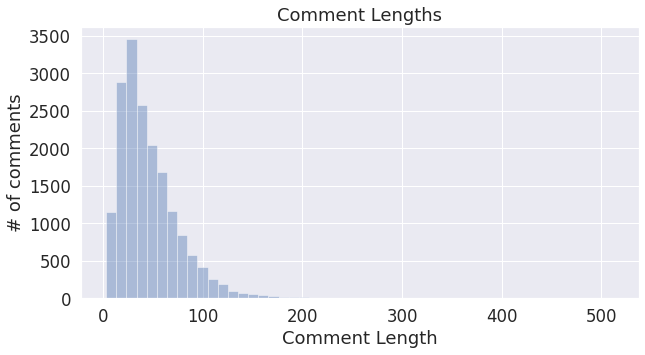

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style = "darkgrid")

# Increase the plot size and the font size
sns.set(font_scale = 1.5)
plt.rcParams["figure.figsize"] = (10, 5)

# Truncate any comment lengths greater than 512
lengths = [min(l, 512) for l in lengths]

# Plot the distribution of comment lengths
sns.distplot(lengths, kde = False, rug = False)

plt.title("Comment Lengths")
plt.xlabel("Comment Length")
plt.ylabel("# of comments")

In [23]:
from keras.preprocessing.sequence import pad_sequences

# Set the required sentence length
MAX_LEN = 128

# Pad our input tokens with value 0
input_ids = pad_sequences(input_ids, maxlen = MAX_LEN, dtype = "long", value = 0, truncating = "post", padding = "post")
print("Done")

Done


In [24]:
attention_masks = []
for sent in input_ids:
  att_mask = [int(token_id > 0) for token_id in sent]

  attention_masks.append(att_mask)

In [25]:
from sklearn.model_selection import train_test_split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, category, random_state = 2018, test_size = 0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, category, random_state = 2018, test_size = 0.1)

In [26]:
import torch
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [27]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

# Create a DataLoader for our validation set
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [28]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)
model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [31]:
import numpy as np

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis = 1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [32]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [33]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 100 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   100  of    497.    Elapsed: 0:01:10.
  Batch   200  of    497.    Elapsed: 0:02:19.
  Batch   300  of    497.    Elapsed: 0:03:27.
  Batch   400  of    497.    Elapsed: 0:04:36.

  Average training loss: 0.14
  Training epcoh took: 0:05:42

Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:14

======== Epoch 2 / 4 ========
Training...
  Batch   100  of    497.    Elapsed: 0:01:09.
  Batch   200  of    497.    Elapsed: 0:02:17.
  Batch   300  of    497.    Elapsed: 0:03:26.
  Batch   400  of    497.    Elapsed: 0:04:34.

  Average training loss: 0.08
  Training epcoh took: 0:05:40

Running Validation...
  Accuracy: 0.96
  Validation took: 0:00:14

======== Epoch 3 / 4 ========
Training...
  Batch   100  of    497.    Elapsed: 0:01:09.
  Batch   200  of    497.    Elapsed: 0:02:17.
  Batch   300  of    497.    Elapsed: 0:03:26.
  Batch   400  of    497.    Elapsed: 0:04:34.

  Average training loss: 0.04
  Training epcoh t

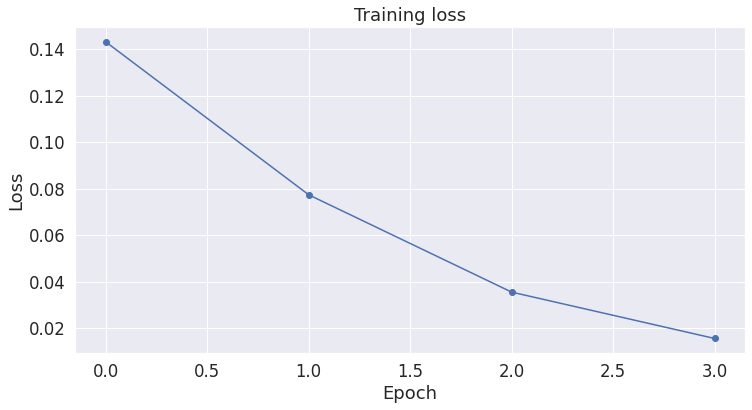

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [35]:
test_input_ids = []
for sen in test_documents.Text:
  if ((len(input_ids) % 2000) == 0):
    print("Read {:,} comments".format(len(input_ids)))
  encoded_sent = tokenizer.encode(sen, add_special_tokens = True, max_length = MAX_LEN)
  test_input_ids.append(encoded_sent)
print("Done")
print("")
print("{:>10,} test comments".format(len(test_input_ids)))

# Retrieve labels as a list
test_category = test_documents.Category.to_numpy()

# Pad our input tokens
test_input_ids = pad_sequences(test_input_ids, maxlen = MAX_LEN, dtype = "long", truncating = "post", padding = "post")

# Create attention masks
test_attention_masks = []

for seq in test_input_ids:
  seq_mask = [float(i>0) for i in seq]
  test_attention_masks.append(seq_mask)

# Convert to tensors
test_inputs = torch.tensor(test_input_ids)
test_masks = torch.tensor(test_attention_masks)
test_labels = torch.tensor(test_category)

batch_size = 32

# Create the dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler,batch_size = batch_size)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Done

     4,412 test comments


In [36]:
print("Predicting labels for {:,} test sentences...".format(len(test_inputs)))
model.eval()

predictions, true_labels = [], []

t0 = time.time()

# Predict
for (step, batch) in enumerate(test_dataloader):
  batch = tuple(t.to(device) for t in batch)

  if step % 100 == 0:
    elapsed = format_time(time.time() - t0)

    print("Batch {:>5,} of {:>5,}. Elapsed: {:}".format(step, len(test_dataloader), elapsed))

  # Unpack the inputs from out dataloader
  b_input_ids, b_input_mask, b_labels = batch

  with torch.no_grad():
    outputs = model(b_input_ids, token_type_ids = None, attention_mask = b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().to("cpu").numpy()
  label_ids = b_labels.to("cpu").numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print("Done")

Predicting labels for 4,412 test sentences...
Batch     0 of   138. Elapsed: 0:00:00
Batch   100 of   138. Elapsed: 0:00:25
Done


In [45]:
b = np.concatenate(true_labels, axis = 0)
b

array([0, 0, 0, ..., 0, 0, 0])

In [38]:
len(b)

4412

In [46]:
a = np.concatenate(predictions, axis = 0)

In [47]:
c = np.argmax(a, axis=1).flatten()
c

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
np.argmax(a, axis=1).flatten()

In [42]:
len(c)

4412

In [53]:
# b = true_labels
# c = predicted_labels
from sklearn.metrics import confusion_matrix
confusion_matrix(b, c)

array([[3978,  120],
       [  81,  233]])

In [ ]:
# Combine the results across the batches
predictions = np.concatenate(predictions, axis = 0)
true_labels = np.concatenate(true_labels, axis = 0)

In [ ]:
len(predictions)

4412

In [ ]:
predictions[0:10]

array([[ 4.31297  , -3.5971   ],
       [ 5.153241 , -4.557267 ],
       [ 4.7580614, -4.16331  ],
       [ 5.185358 , -4.574521 ],
       [ 4.8773813, -4.4285784],
       [ 5.075485 , -4.440483 ],
       [ 4.699029 , -4.316762 ],
       [ 5.069583 , -4.352562 ],
       [ 4.5850053, -3.711985 ],
       [ 5.132287 , -4.4771023]], dtype=float32)

In [ ]:
#for np.argmax(predictions[i], axis = 1).flatten()

In [ ]:
testing11 = []
for i in range(len(predictions)):
  testing11.append(np.argmax(predictions[i], 0))
testing22 = np.array(testing11)
testing22

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import classification_report
names = ['1', '0']
print(classification_report(true_labels, testing22, target_names = names))

              precision    recall  f1-score   support

           1       0.98      0.97      0.97      4098
           0       0.64      0.76      0.70       314

    accuracy                           0.95      4412
   macro avg       0.81      0.86      0.84      4412
weighted avg       0.96      0.95      0.95      4412



In [ ]:
from sklearn.metrics import roc_auc_score

# Use the model output for label 1 as our predictions
p1 = predictions[:,1]

# Calculate ROC AUC
auc = roc_auc_score(true_labels, p1)

print("Test ROC AUC: %.3f", auc)

Test ROC AUC: %.3f 0.9690209298927859


In [ ]:
p1

array([-3.5971   , -4.557267 , -4.16331  , ..., -4.3517294, -4.384686 ,
       -4.235545 ], dtype=float32)

In [ ]:
import os
output_dir = "./model_save/"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s", output_dir)

model_to_save = model.module if hasattr(model, "module") else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to %s ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')